In [26]:
!pip install -q tensorflow==2.1.0
!pip install -q tensorflow-quantum
!pip install qiskit
!pip install cirq

In [82]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import seaborn as sns
import collections


from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit import Aer
from qiskit.compiler import transpile
import numpy as np
from math import sin, cos, atan2
import matplotlib.pyplot as plt
from numpy.linalg import norm,svd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Classical Data Preparation

In [135]:
from google.colab import drive
drive.mount('/content/drive')
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Output_data_ML.npy')

X=X.astype(np.float64)
Y=Y.astype(np.float64)

print(np.shape(X),np.shape(Y))
X.dtype, Y.dtype

'''
X = np.load('Input_data_ML.npy')
Y = np.load('Output_data_ML.npy')
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1070107, 38) (15, 1070107)


"\nX = np.load('Input_data_ML.npy')\nY = np.load('Output_data_ML.npy')\n"

In [136]:
#pca=PCA(n_components=16)
#X=pca.fit_transform(X)

#Expanding X to occupy 6-qubits
X_temp=np.zeros((np.shape(X)[0],64))
X_temp[:,:38]=X
X=X_temp

#scaler2 =StandardScaler()
#X=scaler2.fit_transform(X)

In [137]:
Y=Y.T
Y=Y[:,14]
Y=Y%(2*np.pi)

#Y[:,6:]=Y[:,6:]%(2*np.pi)

'''
y_mean=np.mean(Y)
y_std=np.std(Y)
Y=(Y-y_mean)/y_std/4 

key=np.abs(Y)<1 #keeping values only in 4 sigma
Y=Y[key]
X=X[key]

'''
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std

R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR)))]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR)))]

key=np.abs(Y)<1
Y=Y[key]
X=X[key,:]

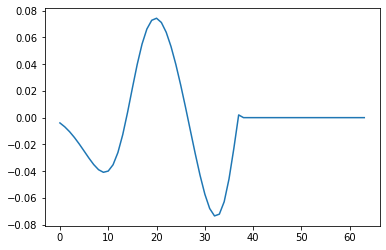

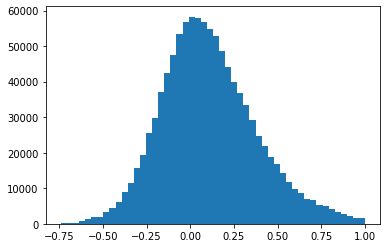

(800, 64) (800,) (200, 64) (200,)


In [138]:
m=np.shape(X)[0]
key=np.random.randint(m,size=1000)

X_small=X[key]
Y_small=Y[key]

plt.plot(X[10000,:])
plt.show()
plt.hist(Y,bins=50)
plt.show()

xtrain, xtest, ytrain, ytest = train_test_split(X_small, Y_small, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

In [112]:
np.std(Y), np.mean(Y)

(0.2702221675788925, 0.10820920499259723)

In [113]:
q=6

## Quantum Data Preparation

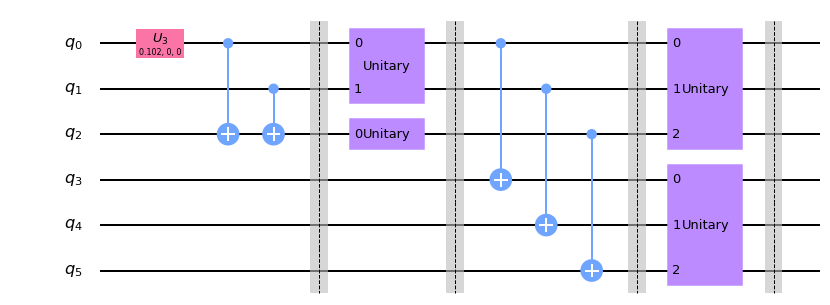

In [114]:
def state_prep(ckt,A,q):
    A=A/np.linalg.norm(A)
    
    if q==1:
        ckt.u3(2*atan2(A[1],A[0]),0,0,0)
        return ckt
    
    n=q-q//2 #n>=m
    m=q//2
    A=np.reshape(A,(2**m,2**n))
    A=np.transpose(A)
    
    U,S,V=np.linalg.svd(A)
    ckt=state_prep(ckt,S,q//2)
    
    for i in range(m):
        ckt.cx(i,i+n)
    if q%2==1:
        ckt.cx(q//2,q-1)
    ckt.barrier()
    
    ckt.unitary(Operator(U), list(range(n)))
    ckt.unitary(Operator(np.transpose(V)), list(range(n,q)))
    ckt.barrier()
    return ckt

A=np.random.rand(2**q)

qiskit_ckt=QuantumCircuit(q)
qiskit_ckt=state_prep(qiskit_ckt,A,q)
qiskit_ckt.draw(output='mpl')

In [115]:
qiskit_ckt=transpile(qiskit_ckt,basis_gates=['cx','u3'])
#qiskit_ckt.draw(output='mpl')

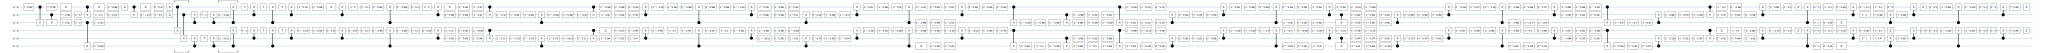

In [116]:
def qiskit_to_cirq(qiskit_ckt,q):
    cirq_ckt=cirq.Circuit()
    cirq_qubits=cirq.GridQubit.rect(1,q)

    for data in qiskit_ckt.data:
        if data[0].name=='u3':
            theta, phi, lambd = data[0]._params
            matrix=np.array([[np.cos(theta/2),-np.exp(1j*lambd)*np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2),np.exp(1j*(phi+lambd))*np.cos(theta/2)]])
            #print(np.array(matrix).round(3))

            synthesized_operations = cirq.single_qubit_matrix_to_gates(matrix)
            for opr in synthesized_operations:
                cirq_ckt.append(opr(cirq_qubits[data[1][0].index]))

        elif data[0].name=='cx':
            cirq_ckt.append(cirq.CNOT(cirq_qubits[data[1][0].index],cirq_qubits[data[1][1].index]))
    return cirq_ckt

cirq_qubits=cirq.GridQubit.rect(1,q)
cirq_ckt=qiskit_to_cirq(qiskit_ckt,q)
SVGCircuit(cirq_ckt)

In [117]:
def Quantum_Data(A,q):
    qiskit_ckt=QuantumCircuit(q)
    qiskit_ckt=state_prep(qiskit_ckt,A,q)
    for i in range(q//2):
        qiskit_ckt.swap(i,q-i-1)
    qiskit_ckt=transpile(qiskit_ckt,basis_gates=['cx','u3'])
    cirq_ckt=qiskit_to_cirq(qiskit_ckt,q)
    return cirq_ckt

#### Testing on Random Input

In [118]:
'''#X_expand=X_expand[:100]
#Y_expand=Y_expand[:100]

q=3

X=np.random.rand(1000,2**q)
X_expand=X/np.reshape(np.linalg.norm(X,axis=1),(-1,1))

Y_expand=np.abs(np.fft.fft(X_expand,axis=1)/np.sqrt(2**q))**2

xtrain, xtest, ytrain, ytest = train_test_split(X_expand, Y_expand, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

t=time.time()
xtrain=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtrain])
xtest=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtest])
print(time.time()-t)
'''

'#X_expand=X_expand[:100]\n#Y_expand=Y_expand[:100]\n\nq=3\n\nX=np.random.rand(1000,2**q)\nX_expand=X/np.reshape(np.linalg.norm(X,axis=1),(-1,1))\n\nY_expand=np.abs(np.fft.fft(X_expand,axis=1)/np.sqrt(2**q))**2\n\nxtrain, xtest, ytrain, ytest = train_test_split(X_expand, Y_expand, test_size=0.2)\nprint(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))\n\nt=time.time()\nxtrain=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtrain])\nxtest=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtest])\nprint(time.time()-t)\n'

#### Working with a small dataset 

In [119]:
t=time.time()
xtrain=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtrain])
xtest=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtest])
print(time.time()-t)

455.8582224845886


## Quantum Neural Network

In [120]:
#TFQ State Layer
'''q0, q1 = cirq.GridQubit.rect(1, 2)
alpha = sympy.Symbol('alpha') # degree of entanglement between q0, q1
parametrized_bell_circuit = cirq.Circuit(
   cirq.H(q0), cirq.CNOT(q0, q1) ** alpha)

state_layer = tfq.layers.State()
alphas = tf.reshape(tf.convert_to_tensor(1),(1,1))
output=state_layer(parametrized_bell_circuit, symbol_names=[alpha], symbol_values=alphas)
print(output)
tf.reduce_mean(tf.abs(output),axis=0)'''

"q0, q1 = cirq.GridQubit.rect(1, 2)\nalpha = sympy.Symbol('alpha') # degree of entanglement between q0, q1\nparametrized_bell_circuit = cirq.Circuit(\n   cirq.H(q0), cirq.CNOT(q0, q1) ** alpha)\n\nstate_layer = tfq.layers.State()\nalphas = tf.reshape(tf.convert_to_tensor(1),(1,1))\noutput=state_layer(parametrized_bell_circuit, symbol_names=[alpha], symbol_values=alphas)\nprint(output)\ntf.reduce_mean(tf.abs(output),axis=0)"

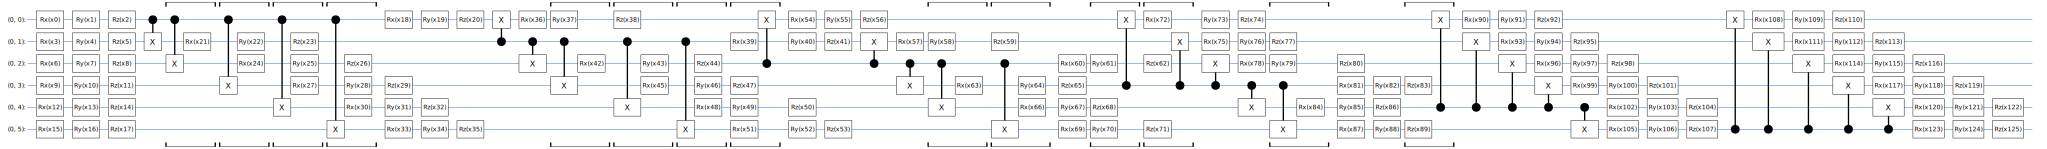

In [121]:
def n_qubit_unitary_gate(n):
    circuit=cirq.Circuit()
    qubits=cirq.GridQubit.rect(1,n)
    x=sympy.symbols('x0:'+str(3*n*(n+1)))
    
    for i in range(n):
        for j in range(n):
            circuit.append(cirq.rx(x[3*n*i+3*j])(qubits[j]))
            circuit.append(cirq.ry(x[3*n*i+3*j+1])(qubits[j]))
            circuit.append(cirq.rz(x[3*n*i+3*j+2])(qubits[j]))
        for j in range(n):
            if i==j: continue
            circuit.append(cirq.CNOT(qubits[i],qubits[j]))
    for j in range(n):
        circuit.append(cirq.rx(x[3*n**2+3*j])(qubits[j]))
        circuit.append(cirq.ry(x[3*n**2+3*j+1])(qubits[j]))
        circuit.append(cirq.rz(x[3*n**2+3*j+2])(qubits[j]))
    return circuit
    
SVGCircuit(n_qubit_unitary_gate(q))

## Readout Operators

In [122]:
def readout_ancilliary(p,q):
    new_p=[]
    for key in p:
        new_p.append(key * 0.5 * (1 + cirq.Z(q)))
    for key in p:
        new_p.append(key * 0.5 * (-cirq.Z(q)+ 1))
    return new_p

In [123]:
def readout(q_out):
    qubits = cirq.GridQubit.rect(1, q_out)

    p0=0.5 * (1 + cirq.Z(qubits[0]))
    p1=0.5 * (-cirq.Z(qubits[0])+ 1)

    read=[p0,p1]

    for i in range(1,q_out):
        read=readout_ancilliary(read,qubits[i])
    return read

def readout2(q_out):
    qubits = cirq.GridQubit.rect(1, q)

    p0=0.5 * (1 + cirq.Z(qubits[q-q_out]))
    p1=0.5 * (-cirq.Z(qubits[q-q_out])+ 1)

    read=[p0,p1]

    for i in range(1,q_out):
        read=readout_ancilliary(read,qubits[i+q-q_out])
    return read

def small_readout(n):
    qubits = cirq.GridQubit.rect(1,n)
    return 0.5 * (1 + cirq.Z(qubits[n-1]))

[0.29681352]


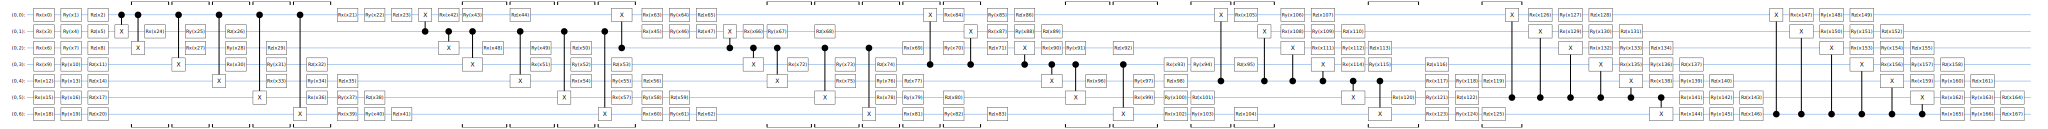

In [124]:
#Testing PQC Readout.
circuit=n_qubit_unitary_gate(q+1)
qubits = cirq.GridQubit.rect(1,q+1)

outputs = tfq.layers.PQC(circuit, cirq.Z(qubits[q]))
quantum_data = tfq.convert_to_tensor([
    cirq.Circuit()
])
res = outputs(quantum_data)
print(np.reshape(res,-1))

SVGCircuit(circuit)

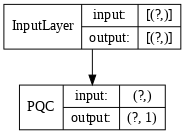

In [125]:
encoded_input=tf.keras.Input(shape=(), dtype=tf.dtypes.string)

output = tfq.layers.PQC(n_qubit_unitary_gate(q+1), cirq.Z(qubits[q]))(encoded_input)
#output = tf.keras.layers.Dense(16, activation='relu')(output)

model = tf.keras.Model(inputs=[encoded_input], outputs=[output])

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=70)

In [126]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                   loss=tf.losses.mse)
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc_7 (PQC)                  (None, 1)                 168       
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________
None


In [127]:
history = model.fit(x=xtrain,
                    y=ytrain,
                    batch_size=16,
                    epochs=8,
                    verbose=1,
                    validation_data=(xtest, ytest))

Train on 800 samples, validate on 200 samples
Epoch 1/8
800/800 [==============================] - 538s 673ms/sample - loss: 0.0645 - val_loss: 0.0700
Epoch 2/8
800/800 [==============================] - 538s 673ms/sample - loss: 0.0595 - val_loss: 0.0697
Epoch 3/8
800/800 [==============================] - 537s 672ms/sample - loss: 0.0601 - val_loss: 0.0693
Epoch 4/8
800/800 [==============================] - 534s 667ms/sample - loss: 0.0603 - val_loss: 0.0718
Epoch 5/8
800/800 [==============================] - 533s 666ms/sample - loss: 0.0598 - val_loss: 0.0682
Epoch 6/8
800/800 [==============================] - 533s 666ms/sample - loss: 0.0589 - val_loss: 0.0714
Epoch 7/8
800/800 [==============================] - 534s 667ms/sample - loss: 0.0599 - val_loss: 0.0696
Epoch 8/8
800/800 [==============================] - 532s 666ms/sample - loss: 0.0587 - val_loss: 0.0689


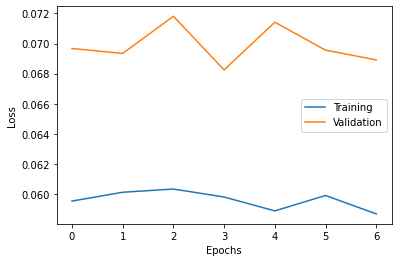

In [128]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [129]:
ytrain_hat=model.predict(xtrain)
ytest_hat=model.predict(xtest)

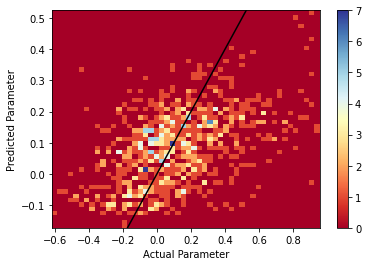

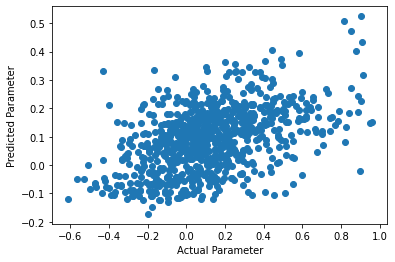

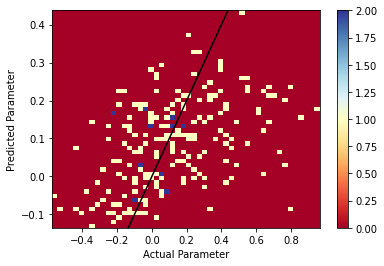

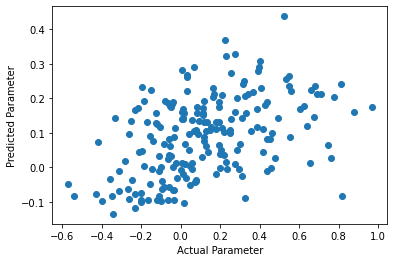

In [130]:
from matplotlib import cm

plt.hist2d(ytrain,ytrain_hat[:,0],bins=50,cmap=cm.RdYlBu) #,range=[[0,0.12],[0,0.12]])
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.colorbar()
plt.plot(np.arange(-1,1,0.01),np.arange(-1,1,0.01),c='k')
plt.show()

plt.scatter(ytrain,ytrain_hat[:,0]) 
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.show()

plt.hist2d(ytest,ytest_hat[:,0],bins=50,cmap=cm.RdYlBu) #,range=[[0,0.12],[0,0.12]])
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.colorbar()
plt.plot(np.arange(-1,1,0.01),np.arange(-1,1,0.01),c='k')
plt.show()

plt.scatter(ytest,ytest_hat[:,0]) 
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.show()

In [131]:
from sklearn.metrics import r2_score 
np.round(r2_score(ytest, ytest_hat[:,0]),3), np.round(r2_score(ytrain, ytrain_hat[:,0]),3)

(0.185, 0.216)

$R^2$ values: \\
6-qubit Unitart Gate: 0.2 \\
7-qubit Unitart Gate: 0.249


In [132]:
#1. Run Time Analysis
#2. Compare PQC using PauliSum against Expectation Layer  (Should be the same)
#PennyLane is Best